In [1]:
%cd ..

/home/ec2-user/uclresearchanalysis


In [2]:
%matplotlib inline
import builtins
builtins.uclresearch_topic = 'GIVENCHY' #0 -- Finished
# builtins.uclresearch_topic = 'HAWKING' #0 -- Finished
# builtins.uclresearch_topic = 'NYC' # 88001
# builtins.uclresearch_topic = 'FLORIDA' # 448387
from configuration import config
from configuration.config import load_ml_data
import xgboost as xgb
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn import svm
from pandas import *
import pandas as pd
from pprint import pprint
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample

import pickle
import shap

import multiprocessing
cpu_count = multiprocessing.cpu_count()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

('Reading config file from location: '
 '/home/ec2-user/uclresearchanalysis/configuration/env.properties')
{'calculate': {'analysis': True,
               'network': True,
               'uniquetweets': True,
               'uniqueusers': True},
 'data': {'dates': ['2018-03-11', '2018-03-12', '2018-03-13'],
          'eventname': "Givenchy's Death",
          'phrases': ['givenchy%20death', 'givenchy%20passed%20away'],
          'starttime': 'Mar 12 08:20:00 -0500 2018'},
 'path': {'crawl': {'followers': '/home/ec2-user/uclresearchanalysis/followers',
                    'friends': '/home/ec2-user/uclresearchanalysis/friends'},
          'cwd': '/home/ec2-user/uclresearchanalysis/data/givenchy',
          'ml': '/home/ec2-user/uclresearchanalysis/data/givenchy/pickle',
          'networkx': {'all': '/home/ec2-user/uclresearchanalysis/data/givenchy/pickle/networkx_all.dat',
                       'friends': '/home/ec2-user/uclresearchanalysis/data/givenchy/pickle/networkx_friends.dat',


In [3]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [4]:
# Parameters
interval = 30

# 1. Prepare
def prepare_data(interval):
    df = load_ml_data(interval)
    df = df.reset_index(drop=True)
    
    # Converting all type to float, to prepare for feature selection
    df = df.astype('float')
    # Reset index, with drop equals to true to avoid setting old index as a new column
    df = df.reset_index(drop=True)
    # Visualize distribution
    print('[Original] data counts, with uninfected (0): {}, infected (1): {}'.format(
        df['label'].value_counts()[0],
        df['label'].value_counts()[1]
    ))
    df.groupby(['TwM_tCurrent','label']).size().unstack(fill_value=0).plot.bar(title='Original Data Distribution')
    
    columns = list(df.columns)
    columns.remove('label')
    
    X = df[columns]
    y = df[['label']]
    return df, X, y


Loading data file from path /home/ec2-user/uclresearchanalysis/data/givenchy/pickle/30_data.dat
'Loaded 55559 entires'
[Original] data counts, with uninfected (0): 45777, infected (1): 9782


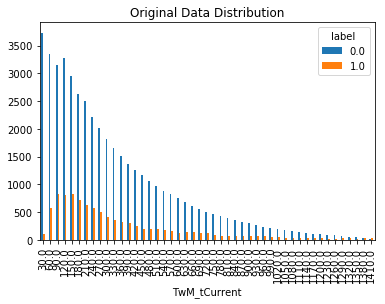

In [5]:
# 1. Prepare
df, X, y = prepare_data(interval)

In [6]:
feature_columns = X.columns
print('There are {} Features'.format(len(feature_columns)))

There are 88 Features


In [7]:
def upsample(df):
    # Separate majority and minority classes
    df_majority = df[df.label==0] # Uninfected is the major class
    df_minority = df[df.label==1] # Infected is the minor class

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(df_majority),    # to match majority class
                                     random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    # Display new class counts
    print(df_upsampled.label.value_counts())
    
    return df_upsampled

In [8]:
def downsample(df):
    # Separate majority and minority classes
    df_majority = df[df.label==0] # Uninfected is the major class
    df_minority = df[df.label==1] # Infected is the minor class

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                     replace=False,    # sample without replacement
                                     n_samples=len(df_minority),     # to match minority class
                                     random_state=123) # reproducible results

    # Combine minority class with downsampled majority class
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])

    # Display new class counts
    print(df_downsampled.label.value_counts())
    
    return df_downsampled

In [9]:
def train(df, X, y, params, n_folds, num_boost_round, rebalance_method):
    # 2. N Fold Split
    # Stratified K-Folds cross-validator
    # Provides train/test indices to split data in train/test sets. 
    # This cross-validation object is a variation of KFold that returns stratified folds. 
    # The folds are made by preserving the percentage of samples for each class.
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
    
    corrDataframe = pd.DataFrame()    
    mse = []
    acc = []
    roc = []
    F1 = []
    auc = []
    auc_t = []
    acc_t = []
    fold_count = 0
    t_current = 210
    number_of_features = len(X.columns)

    print("Start cross validation")
    for train, test in skf.split(X, y):
        print("===Processing fold %s===" % fold_count)
        train_fold = df.loc[train]
        test_fold = df.loc[test]

        # 3. Rebalance
        if rebalance_method == 'up':
            train_fold = upsample(train_fold)
        if rebalance_method == 'down':
            train_fold = downsample(train_fold)
         
        # 4. Feature Selection
#         corr = train_fold.corr()['label'][train_fold.corr()['label'] < 1].abs()
#         corr = corr.sort_values(ascending=False)
#         corrDataframe = corrDataframe.append(pd.DataFrame(corr.rename('cv{}'.format(fold_count))).T)
#         features = corr.index[range(number_of_features)].values
        features = X.columns
        
        # 5. Training
        # Fit Model
        xgtrain = xgb.DMatrix(train_fold[features].values, train_fold['label'].values)
        xgtest = xgb.DMatrix(test_fold[features].values, test_fold['label'].values)
        evallist = [(xgtrain, 'train'),(xgtest,'eval')]
#         evallist = []
        
        bst = xgb.train(params, xgtrain, 
                        num_boost_round = num_boost_round, 
                        evals = evallist)

        # 6. Testing
        # Check MSE on test set
        
        test_fold_t = test_fold[test_fold.TwM_tCurrent == t_current]
#             xgtest = xgb.DMatrix(test_fold[features].values)
        xgtest_t = xgb.DMatrix(test_fold_t[features].values)
        pred = bst.predict(xgtest)
        pred_t = bst.predict(xgtest_t)

        mse.append(mean_squared_error(test_fold['label'], pred))
        roc.append(roc_auc_score(test_fold['label'], pred))
        auc_t.append(roc_auc_score(test_fold_t['label'], pred_t))

        acc.append(accuracy_score(test_fold['label'], (pred>0.5).astype(int)))
        acc_t.append(accuracy_score(test_fold_t['label'], (pred_t>0.5).astype(int)))
        F1.append(f1_score(test_fold['label'],(pred>0.5).astype(int)))
        cm = confusion_matrix(test_fold['label'], (pred>0.5).astype(int))
        plot_confusion_matrix(cm, 
                              normalize    = True,
                              target_names = ['Uninfected', 'Infected'],
                              title        = "Confusion Matrix, Normalized")


        fold_count += 1
        # Done with the fold
    print("Finished cross validation")
    print("MSE: {} ".format(DataFrame(mse).mean()))
    print("ACC: {} ".format(DataFrame(acc).mean()))
    print("AUC: {} ".format(DataFrame(roc).mean()))
#     print("F1: {} ".format(DataFrame(F1).mean()))
    print("ACC for t at {}: {} ".format(t_current, DataFrame(acc_t).mean()))
    corrDataframe = corrDataframe.T
    corrDataframe['average corr'] = corrDataframe.mean(numeric_only=True, axis=1)
    print(corrDataframe.sort_values(by=['average corr'], ascending=False).to_string())

    return bst


In [10]:
#xgboost
param = {
    'max_depth':3,
    # Step size shrinkage used in update to prevents overfitting. 
    # After each boosting step, we can directly get the weights of new features, 
    # and eta shrinks the feature weights to make the boosting process more conservative.
    'eta': 0.1,
    # Minimum loss reduction required to make a further partition on a leaf node of the tree. 
    # The larger gamma is, the more conservative the algorithm will be.
    'gamma':10,
    # Minimum sum of instance weight (hessian) needed in a child. 
    # If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, 
    # then the building process will give up further partitioning.
    # The larger min_child_weight is, the more conservative the algorithm will be.
    'min_child_weight':10,
    'silent': 1, # 0 means printing running messages, 1 means silent mode
    'objective': 'binary:logistic',
    'subsample': 0.9
}
param['nthread'] = cpu_count
param['eval_metric'] = ['auc']
num_boost_round = 1000
rebalance_method = 'up'

Start cross validation
===Processing fold 0===
1.0    22888
0.0    22888
Name: label, dtype: int64
[0]	train-auc:0.614117	eval-auc:0.613537
[1]	train-auc:0.623098	eval-auc:0.622229
[2]	train-auc:0.623799	eval-auc:0.623351
[3]	train-auc:0.629143	eval-auc:0.627111
[4]	train-auc:0.629027	eval-auc:0.627465
[5]	train-auc:0.62952	eval-auc:0.629494
[6]	train-auc:0.631291	eval-auc:0.630639
[7]	train-auc:0.634282	eval-auc:0.631685
[8]	train-auc:0.63445	eval-auc:0.63177
[9]	train-auc:0.638832	eval-auc:0.635095
[10]	train-auc:0.640835	eval-auc:0.637021
[11]	train-auc:0.643076	eval-auc:0.636583
[12]	train-auc:0.644951	eval-auc:0.636952
[13]	train-auc:0.646707	eval-auc:0.637551
[14]	train-auc:0.647629	eval-auc:0.638135
[15]	train-auc:0.649291	eval-auc:0.639514
[16]	train-auc:0.650802	eval-auc:0.640467
[17]	train-auc:0.651587	eval-auc:0.640568
[18]	train-auc:0.653015	eval-auc:0.64157
[19]	train-auc:0.653237	eval-auc:0.6419
[20]	train-auc:0.65449	eval-auc:0.642507
[21]	train-auc:0.655834	eval-auc:0.6

[192]	train-auc:0.764671	eval-auc:0.678656
[193]	train-auc:0.764911	eval-auc:0.678737
[194]	train-auc:0.765643	eval-auc:0.678495
[195]	train-auc:0.765843	eval-auc:0.678519
[196]	train-auc:0.765913	eval-auc:0.678546
[197]	train-auc:0.765944	eval-auc:0.678506
[198]	train-auc:0.766121	eval-auc:0.678623
[199]	train-auc:0.766147	eval-auc:0.678633
[200]	train-auc:0.766604	eval-auc:0.67862
[201]	train-auc:0.766939	eval-auc:0.678601
[202]	train-auc:0.767342	eval-auc:0.67874
[203]	train-auc:0.767834	eval-auc:0.678899
[204]	train-auc:0.768311	eval-auc:0.678929
[205]	train-auc:0.768838	eval-auc:0.678943
[206]	train-auc:0.769233	eval-auc:0.679084
[207]	train-auc:0.76961	eval-auc:0.679006
[208]	train-auc:0.769867	eval-auc:0.679068
[209]	train-auc:0.770498	eval-auc:0.679125
[210]	train-auc:0.770512	eval-auc:0.679111
[211]	train-auc:0.7706	eval-auc:0.679181
[212]	train-auc:0.771001	eval-auc:0.679357
[213]	train-auc:0.771321	eval-auc:0.679384
[214]	train-auc:0.77158	eval-auc:0.679386
[215]	train-auc:0

[384]	train-auc:0.820153	eval-auc:0.692316
[385]	train-auc:0.820209	eval-auc:0.692288
[386]	train-auc:0.82079	eval-auc:0.692621
[387]	train-auc:0.82076	eval-auc:0.692603
[388]	train-auc:0.820789	eval-auc:0.692603
[389]	train-auc:0.82089	eval-auc:0.69261
[390]	train-auc:0.820974	eval-auc:0.692655
[391]	train-auc:0.821241	eval-auc:0.692718
[392]	train-auc:0.82133	eval-auc:0.692781
[393]	train-auc:0.82149	eval-auc:0.692943
[394]	train-auc:0.82149	eval-auc:0.692943
[395]	train-auc:0.821865	eval-auc:0.692838
[396]	train-auc:0.82244	eval-auc:0.692971
[397]	train-auc:0.82244	eval-auc:0.692971
[398]	train-auc:0.822521	eval-auc:0.693067
[399]	train-auc:0.822565	eval-auc:0.693156
[400]	train-auc:0.822565	eval-auc:0.693156
[401]	train-auc:0.822685	eval-auc:0.693185
[402]	train-auc:0.82283	eval-auc:0.6933
[403]	train-auc:0.822854	eval-auc:0.693354
[404]	train-auc:0.82308	eval-auc:0.693349
[405]	train-auc:0.82318	eval-auc:0.693429
[406]	train-auc:0.823752	eval-auc:0.693581
[407]	train-auc:0.823809	

[576]	train-auc:0.854204	eval-auc:0.701662
[577]	train-auc:0.85441	eval-auc:0.701587
[578]	train-auc:0.854453	eval-auc:0.701601
[579]	train-auc:0.854453	eval-auc:0.701601
[580]	train-auc:0.854545	eval-auc:0.701572
[581]	train-auc:0.854545	eval-auc:0.701572
[582]	train-auc:0.854545	eval-auc:0.701572
[583]	train-auc:0.854768	eval-auc:0.701749
[584]	train-auc:0.854799	eval-auc:0.701771
[585]	train-auc:0.854799	eval-auc:0.701771
[586]	train-auc:0.85508	eval-auc:0.701765
[587]	train-auc:0.855039	eval-auc:0.7019
[588]	train-auc:0.855163	eval-auc:0.701961
[589]	train-auc:0.855334	eval-auc:0.701905
[590]	train-auc:0.855334	eval-auc:0.701905
[591]	train-auc:0.855414	eval-auc:0.701814
[592]	train-auc:0.855414	eval-auc:0.701814
[593]	train-auc:0.855414	eval-auc:0.701814
[594]	train-auc:0.855692	eval-auc:0.701784
[595]	train-auc:0.855912	eval-auc:0.701857
[596]	train-auc:0.856165	eval-auc:0.701966
[597]	train-auc:0.856244	eval-auc:0.701979
[598]	train-auc:0.856605	eval-auc:0.702098
[599]	train-auc

[768]	train-auc:0.875327	eval-auc:0.706891
[769]	train-auc:0.875327	eval-auc:0.706891
[770]	train-auc:0.875337	eval-auc:0.706957
[771]	train-auc:0.875458	eval-auc:0.707048
[772]	train-auc:0.875601	eval-auc:0.706952
[773]	train-auc:0.875682	eval-auc:0.706863
[774]	train-auc:0.875821	eval-auc:0.706865
[775]	train-auc:0.875947	eval-auc:0.706894
[776]	train-auc:0.8761	eval-auc:0.707004
[777]	train-auc:0.876148	eval-auc:0.707013
[778]	train-auc:0.87647	eval-auc:0.707
[779]	train-auc:0.876563	eval-auc:0.707
[780]	train-auc:0.87665	eval-auc:0.706977
[781]	train-auc:0.876742	eval-auc:0.707042
[782]	train-auc:0.876906	eval-auc:0.707163
[783]	train-auc:0.876953	eval-auc:0.707169
[784]	train-auc:0.876953	eval-auc:0.707169
[785]	train-auc:0.876954	eval-auc:0.707133
[786]	train-auc:0.877143	eval-auc:0.707087
[787]	train-auc:0.877311	eval-auc:0.707043
[788]	train-auc:0.877448	eval-auc:0.707219
[789]	train-auc:0.877515	eval-auc:0.707218
[790]	train-auc:0.877515	eval-auc:0.707218
[791]	train-auc:0.877

[960]	train-auc:0.890177	eval-auc:0.711238
[961]	train-auc:0.890177	eval-auc:0.711238
[962]	train-auc:0.890177	eval-auc:0.711238
[963]	train-auc:0.890177	eval-auc:0.711238
[964]	train-auc:0.890173	eval-auc:0.711209
[965]	train-auc:0.890173	eval-auc:0.711209
[966]	train-auc:0.890206	eval-auc:0.711215
[967]	train-auc:0.890206	eval-auc:0.711215
[968]	train-auc:0.890385	eval-auc:0.711369
[969]	train-auc:0.890444	eval-auc:0.711382
[970]	train-auc:0.890564	eval-auc:0.711422
[971]	train-auc:0.890597	eval-auc:0.711455
[972]	train-auc:0.890566	eval-auc:0.711505
[973]	train-auc:0.890566	eval-auc:0.711505
[974]	train-auc:0.890766	eval-auc:0.7115
[975]	train-auc:0.890766	eval-auc:0.7115
[976]	train-auc:0.890766	eval-auc:0.7115
[977]	train-auc:0.890766	eval-auc:0.7115
[978]	train-auc:0.890999	eval-auc:0.711582
[979]	train-auc:0.891134	eval-auc:0.711542
[980]	train-auc:0.891299	eval-auc:0.711595
[981]	train-auc:0.891403	eval-auc:0.711654
[982]	train-auc:0.891403	eval-auc:0.711654
[983]	train-auc:0.8

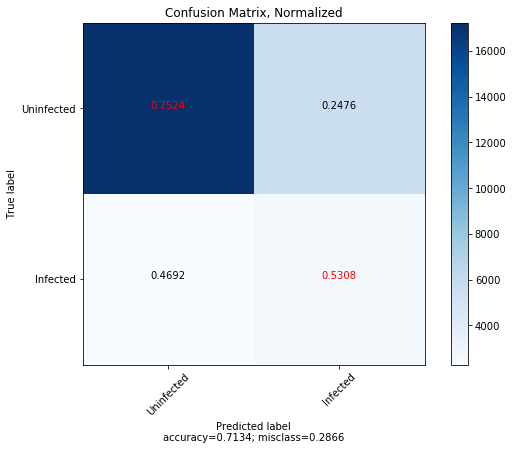

===Processing fold 1===
1.0    22889
0.0    22889
Name: label, dtype: int64
[0]	train-auc:0.614229	eval-auc:0.59765
[1]	train-auc:0.624331	eval-auc:0.607103
[2]	train-auc:0.636454	eval-auc:0.618403
[3]	train-auc:0.637987	eval-auc:0.618075
[4]	train-auc:0.639042	eval-auc:0.618059
[5]	train-auc:0.641227	eval-auc:0.620482
[6]	train-auc:0.64065	eval-auc:0.619147
[7]	train-auc:0.640483	eval-auc:0.619226
[8]	train-auc:0.64479	eval-auc:0.621877
[9]	train-auc:0.647177	eval-auc:0.621751
[10]	train-auc:0.649252	eval-auc:0.624675
[11]	train-auc:0.651783	eval-auc:0.626796
[12]	train-auc:0.653465	eval-auc:0.627938
[13]	train-auc:0.656645	eval-auc:0.629594
[14]	train-auc:0.657966	eval-auc:0.630088
[15]	train-auc:0.659918	eval-auc:0.631368
[16]	train-auc:0.662037	eval-auc:0.63278
[17]	train-auc:0.663725	eval-auc:0.633716
[18]	train-auc:0.664936	eval-auc:0.633867
[19]	train-auc:0.666432	eval-auc:0.63487
[20]	train-auc:0.667704	eval-auc:0.635175
[21]	train-auc:0.668299	eval-auc:0.63545
[22]	train-auc:0

[193]	train-auc:0.768703	eval-auc:0.663602
[194]	train-auc:0.769065	eval-auc:0.663873
[195]	train-auc:0.769379	eval-auc:0.66381
[196]	train-auc:0.769452	eval-auc:0.663755
[197]	train-auc:0.769555	eval-auc:0.663835
[198]	train-auc:0.769682	eval-auc:0.663788
[199]	train-auc:0.77001	eval-auc:0.663926
[200]	train-auc:0.770183	eval-auc:0.663924
[201]	train-auc:0.770501	eval-auc:0.664028
[202]	train-auc:0.770925	eval-auc:0.664194
[203]	train-auc:0.77101	eval-auc:0.664256
[204]	train-auc:0.771295	eval-auc:0.664435
[205]	train-auc:0.771489	eval-auc:0.664423
[206]	train-auc:0.771515	eval-auc:0.664442
[207]	train-auc:0.771987	eval-auc:0.664483
[208]	train-auc:0.772275	eval-auc:0.664597
[209]	train-auc:0.772395	eval-auc:0.664566
[210]	train-auc:0.772542	eval-auc:0.66444
[211]	train-auc:0.772734	eval-auc:0.664548
[212]	train-auc:0.772922	eval-auc:0.664741
[213]	train-auc:0.773028	eval-auc:0.66484
[214]	train-auc:0.773104	eval-auc:0.664832
[215]	train-auc:0.774309	eval-auc:0.664884
[216]	train-auc:

[385]	train-auc:0.820834	eval-auc:0.677254
[386]	train-auc:0.821118	eval-auc:0.677228
[387]	train-auc:0.821299	eval-auc:0.677182
[388]	train-auc:0.821549	eval-auc:0.677084
[389]	train-auc:0.821635	eval-auc:0.677096
[390]	train-auc:0.821708	eval-auc:0.677052
[391]	train-auc:0.821766	eval-auc:0.677111
[392]	train-auc:0.821951	eval-auc:0.677179
[393]	train-auc:0.822174	eval-auc:0.677163
[394]	train-auc:0.82225	eval-auc:0.677115
[395]	train-auc:0.82225	eval-auc:0.677115
[396]	train-auc:0.822269	eval-auc:0.677192
[397]	train-auc:0.822424	eval-auc:0.677239
[398]	train-auc:0.822457	eval-auc:0.677194
[399]	train-auc:0.822688	eval-auc:0.677318
[400]	train-auc:0.822773	eval-auc:0.677392
[401]	train-auc:0.822959	eval-auc:0.677445
[402]	train-auc:0.823409	eval-auc:0.67767
[403]	train-auc:0.823588	eval-auc:0.677652
[404]	train-auc:0.823999	eval-auc:0.677934
[405]	train-auc:0.824331	eval-auc:0.678097
[406]	train-auc:0.824408	eval-auc:0.678166
[407]	train-auc:0.824661	eval-auc:0.67842
[408]	train-auc

[577]	train-auc:0.854261	eval-auc:0.684924
[578]	train-auc:0.854406	eval-auc:0.685101
[579]	train-auc:0.85445	eval-auc:0.684977
[580]	train-auc:0.854868	eval-auc:0.685127
[581]	train-auc:0.854959	eval-auc:0.685066
[582]	train-auc:0.855011	eval-auc:0.685011
[583]	train-auc:0.855185	eval-auc:0.685023
[584]	train-auc:0.855255	eval-auc:0.685061
[585]	train-auc:0.855255	eval-auc:0.685061
[586]	train-auc:0.855469	eval-auc:0.685071
[587]	train-auc:0.855588	eval-auc:0.685053
[588]	train-auc:0.855771	eval-auc:0.685203
[589]	train-auc:0.855771	eval-auc:0.685203
[590]	train-auc:0.855968	eval-auc:0.68525
[591]	train-auc:0.855968	eval-auc:0.68525
[592]	train-auc:0.855981	eval-auc:0.685286
[593]	train-auc:0.856222	eval-auc:0.685369
[594]	train-auc:0.856512	eval-auc:0.685363
[595]	train-auc:0.856576	eval-auc:0.685349
[596]	train-auc:0.856665	eval-auc:0.685312
[597]	train-auc:0.857114	eval-auc:0.685343
[598]	train-auc:0.857305	eval-auc:0.685296
[599]	train-auc:0.857586	eval-auc:0.685268
[600]	train-au

[769]	train-auc:0.876959	eval-auc:0.69121
[770]	train-auc:0.876959	eval-auc:0.69121
[771]	train-auc:0.877069	eval-auc:0.691178
[772]	train-auc:0.877204	eval-auc:0.691181
[773]	train-auc:0.877204	eval-auc:0.691181
[774]	train-auc:0.877222	eval-auc:0.691169
[775]	train-auc:0.877247	eval-auc:0.691121
[776]	train-auc:0.877597	eval-auc:0.691139
[777]	train-auc:0.877597	eval-auc:0.691139
[778]	train-auc:0.877597	eval-auc:0.691139
[779]	train-auc:0.877612	eval-auc:0.691129
[780]	train-auc:0.877676	eval-auc:0.691062
[781]	train-auc:0.877751	eval-auc:0.691174
[782]	train-auc:0.877912	eval-auc:0.691231
[783]	train-auc:0.877912	eval-auc:0.691231
[784]	train-auc:0.877997	eval-auc:0.691339
[785]	train-auc:0.878166	eval-auc:0.691363
[786]	train-auc:0.878166	eval-auc:0.691363
[787]	train-auc:0.8783	eval-auc:0.691411
[788]	train-auc:0.878376	eval-auc:0.691496
[789]	train-auc:0.878462	eval-auc:0.691559
[790]	train-auc:0.878476	eval-auc:0.691592
[791]	train-auc:0.878476	eval-auc:0.691592
[792]	train-auc

[961]	train-auc:0.89135	eval-auc:0.696113
[962]	train-auc:0.891623	eval-auc:0.696162
[963]	train-auc:0.891688	eval-auc:0.696165
[964]	train-auc:0.891704	eval-auc:0.696167
[965]	train-auc:0.891704	eval-auc:0.696167
[966]	train-auc:0.891729	eval-auc:0.696122
[967]	train-auc:0.891729	eval-auc:0.696122
[968]	train-auc:0.891769	eval-auc:0.69609
[969]	train-auc:0.891847	eval-auc:0.696209
[970]	train-auc:0.891804	eval-auc:0.696245
[971]	train-auc:0.89186	eval-auc:0.69643
[972]	train-auc:0.891877	eval-auc:0.69643
[973]	train-auc:0.892058	eval-auc:0.696566
[974]	train-auc:0.892058	eval-auc:0.696566
[975]	train-auc:0.89216	eval-auc:0.696555
[976]	train-auc:0.89216	eval-auc:0.696555
[977]	train-auc:0.892301	eval-auc:0.696578
[978]	train-auc:0.892408	eval-auc:0.696655
[979]	train-auc:0.892515	eval-auc:0.696596
[980]	train-auc:0.892524	eval-auc:0.696629
[981]	train-auc:0.892585	eval-auc:0.696652
[982]	train-auc:0.89272	eval-auc:0.696684
[983]	train-auc:0.89272	eval-auc:0.696684
[984]	train-auc:0.89

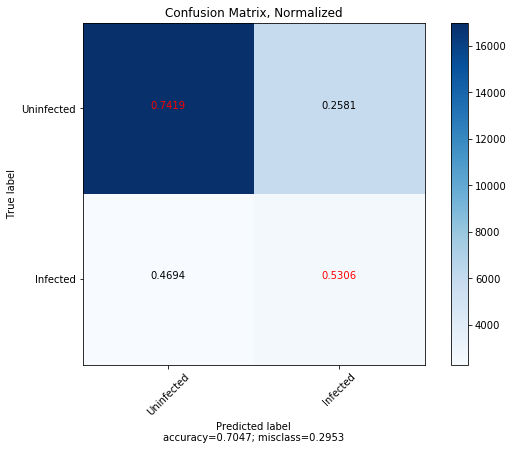

Finished cross validation
MSE: 0    0.192449
dtype: float64 
ACC: 0    0.709012
dtype: float64 
AUC: 0    0.704635
dtype: float64 
ACC for t at 210: 0    0.657267
dtype: float64 
Empty DataFrame
Columns: [average corr]
Index: []


In [11]:
xgb_model = train(df, X, y, param, 2, num_boost_round, rebalance_method)

In [12]:
columns = list(df.columns)
columns.remove('label')
if rebalance_method == 'up':
    df_rebalance = upsample(df)
if rebalance_method == 'down':
    df_rebalance = downsample(df)
X = df_rebalance[columns]
y = df_rebalance[['label']]

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model

model = xgb.train(param, xgb.DMatrix(X, label=y), num_boost_round)

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

1.0    45777
0.0    45777
Name: label, dtype: int64


In [13]:
with open('xgb_model.dat', 'wb') as file:
    pickle.dump(model, file)

In [14]:
subsample = list(range(1,len(shap_values),int(len(shap_values)/1000)))

In [15]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values[subsample,:], X.iloc[subsample,:])

In [16]:
X.columns[0]

'UsM_deltaDays'

In [17]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot(X.columns[0], shap_values, X)

KeyboardInterrupt: 

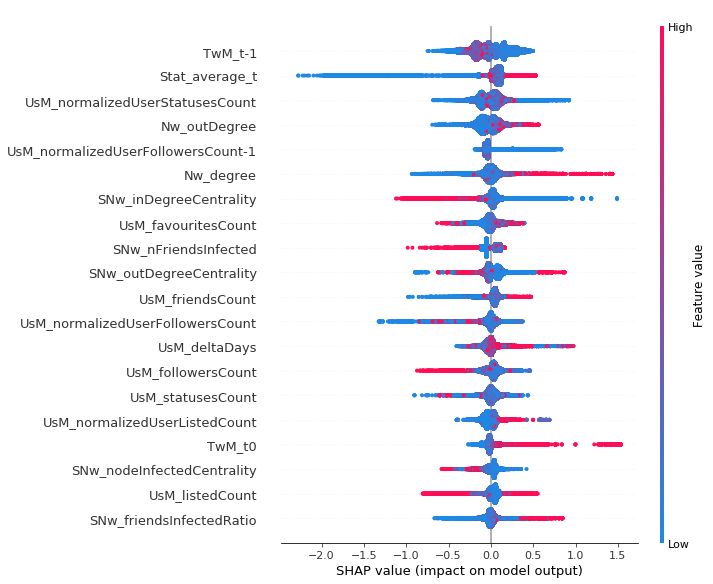

In [18]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

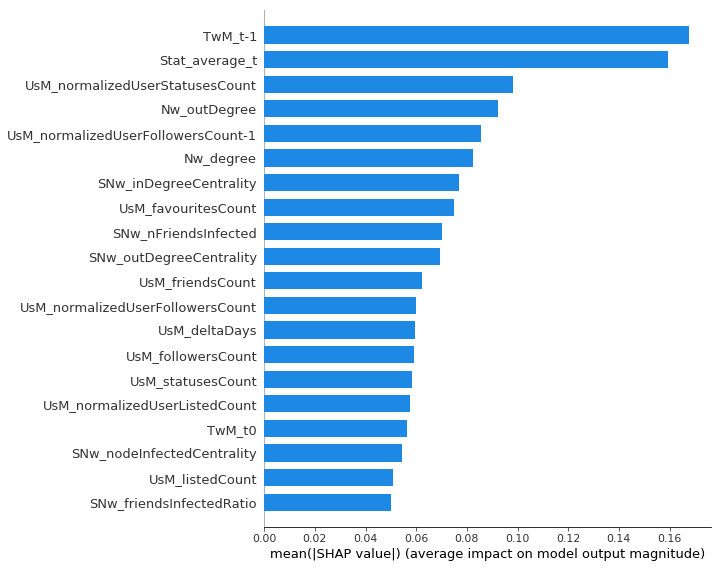

In [19]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [ ]:
import matplotlib.pyplot as plt

xgb.plot_tree(xgb_model, num_trees=1)

fig = plt.gcf()
fig.set_size_inches(100, 50)
plt.show()

In [ ]:
xgb.plot_importance(xgb_model)
fig = plt.gcf()
# fig.set_size_inches(50, 100)
plt.show()